# ***Statistical Theory - Final Project***

**Ron Libman - 211540265, Omer Shadmi - 327722575.**

-----------

## **Background**

This project investigates whether left-footed football players possess distinct advantages over their right-footed counterparts by analyzing a comprehensive dataset of ~18,000 players from FIFA19. The attributes examined include dribbling, crossing, curve, and freekick accuracy, areas where left-footed players were hypothesized to excel. A combination of statistical tests and machine learning models was employed to compare the performance of players based on their foot preference. The analysis revealed some significant differences, suggesting that left-footed players may have advantages in specific technical skills. However, further research is needed to conclusively determine whether these differences are due to foot preference alone, as additional factors such as player roles, tactical decisions, and other confounding variables may also play a role.

---------

## **Preperations**

In [59]:
!pip install shap
!pip install soccerplots
!pip install statsmodels

### <u>Imports:</u>

In [77]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import shap
import statsmodels
from soccerplots.radar_chart import Radar
from matplotlib.colors import ListedColormap

pd.set_option('display.max_rows', 1000)
warnings.filterwarnings("ignore")

### <u>Loading the dataset:</u>

In [61]:
df = pd.read_csv('fifa_players.csv')

----------

## **Data Preprocessing and EDA**

In [62]:
print("Dataset overview:")
print(df.info())
print(df.describe())

# Check for missing values
print("Missing values:")
print(df.isnull().sum())

# Distribution of preferred foot
print("Distribution of preferred foot:")
print(df['preferred_foot'].value_counts())

Dataset overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17954 entries, 0 to 17953
Data columns (total 51 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   name                           17954 non-null  object 
 1   full_name                      17954 non-null  object 
 2   birth_date                     17954 non-null  object 
 3   age                            17954 non-null  int64  
 4   height_cm                      17954 non-null  float64
 5   weight_kgs                     17954 non-null  float64
 6   positions                      17954 non-null  object 
 7   nationality                    17954 non-null  object 
 8   overall_rating                 17954 non-null  int64  
 9   potential                      17954 non-null  int64  
 10  value_euro                     17699 non-null  float64
 11  wage_euro                      17708 non-null  float64
 12  preferred_foot              

In [63]:
df.columns

Index(['name', 'full_name', 'birth_date', 'age', 'height_cm', 'weight_kgs',
       'positions', 'nationality', 'overall_rating', 'potential', 'value_euro',
       'wage_euro', 'preferred_foot', 'international_reputation(1-5)',
       'weak_foot(1-5)', 'skill_moves(1-5)', 'body_type',
       'release_clause_euro', 'national_team', 'national_rating',
       'national_team_position', 'national_jersey_number', 'crossing',
       'finishing', 'heading_accuracy', 'short_passing', 'volleys',
       'dribbling', 'curve', 'freekick_accuracy', 'long_passing',
       'ball_control', 'acceleration', 'sprint_speed', 'agility', 'reactions',
       'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots',
       'aggression', 'interceptions', 'positioning', 'vision', 'penalties',
       'composure', 'marking', 'standing_tackle', 'sliding_tackle'],
      dtype='object')

Now we check the stats (like mean, std...) for the features, by the preferred foot of the player:

In [64]:
# Stats of features per preferred foot
grouped_stats = df.groupby('preferred_foot').describe().transpose()
grouped_stats = grouped_stats.applymap(lambda x: f"{x:.2f}")

grouped_stats

preferred_foot                               Left         Right
age                           count       4173.00      13781.00
                              mean          25.55         25.57
                              std            4.58          4.74
                              min           17.00         17.00
                              25%           22.00         22.00
                              50%           25.00         25.00
                              75%           29.00         29.00
                              max           42.00         46.00
height_cm                     count       4173.00      13781.00
                              mean         173.67        175.33
                              std           13.67         14.11
                              min          152.40        152.40
                              25%          154.94        162.56
                              50%          175.26        182.88
                              75%          185.42        185.42
                              max          203.20        205.74
weight_kgs                    count       4173.00      13781.00
                              mean          74.36         75.59
                              std            6.90          7.12
                              min           49.90         49.90
                              25%           69.90         69.90
                              50%           73.90         74.80
                              75%           78.90         79.80
                              max           98.90        110.20
overall_rating                count       4173.00      13781.00
                              mean          66.84         66.06
                              std            6.57          7.07
                              min           47.00         47.00
                              25%           63.00         62.00
                              50%           67.00         66.00
                              75%           71.00         71.00
                              max           94.00         94.00
potential                     count       4173.00      13781.00
                              mean          71.89         71.29
                              std            6.08          6.14
                              min           53.00         48.00
                              25%           68.00         67.00
                              50%           72.00         71.00
                              75%           76.00         75.00
                              max           94.00         95.00
value_euro                    count       4120.00      13579.00
                              mean     2656160.19    2425613.08
                              std      5990822.70    5590695.02
                              min        10000.00      10000.00
                              25%       400000.00     300000.00
                              50%       775000.00     675000.00
                              75%      2400000.00    2000000.00
                              max    110500000.00  108000000.00
wage_euro                     count       4123.00      13585.00
                              mean       10568.76       9699.82
                              std        23501.40      21514.58
                              min         1000.00       1000.00
                              25%         2000.00       1000.00
                              50%         4000.00       3000.00
                              75%        10000.00       9000.00
                              max       565000.00     455000.00
international_reputation(1-5) count       4173.00      13781.00
                              mean           1.11          1.11
                              std            0.39          0.39
                              min            1.00          1.00
                              25%            1.00          1.00
                              50

We can see that there is a significant advantage for the right-footed player, in terms of average, in many of the features (such as: dribbling, crossing, curve, freekick_accuracy, etc.). We will treat these features as our "suspicious" features, for the rest of our analysing.

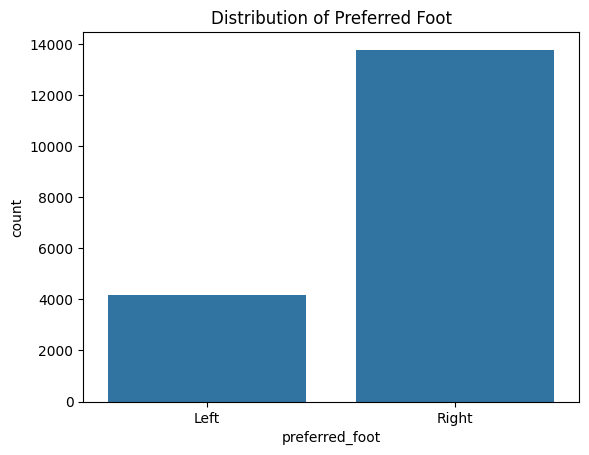

In [65]:
# Visualize distribution of preferred foot
sns.countplot(data=df, x='preferred_foot')
plt.title('Distribution of Preferred Foot')
plt.show()

In [66]:
# Distribution of preferred foot
df['preferred_foot'].value_counts()

,count
preferred_foot,
Right,13781
Left,4173


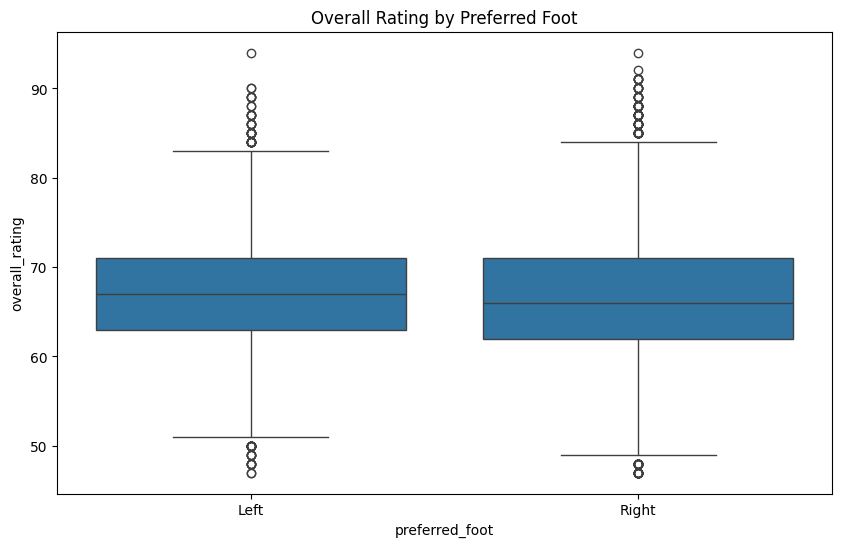

In [67]:
# Compare overall rating by preferred foot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='preferred_foot', y='overall_rating')
plt.title('Overall Rating by Preferred Foot')
plt.show()

As we can see, the average rating value for left-footed players is slightly higher.

Now, we want to look at the mean for some of the interesting features, again: right-footed vs. left-footed.

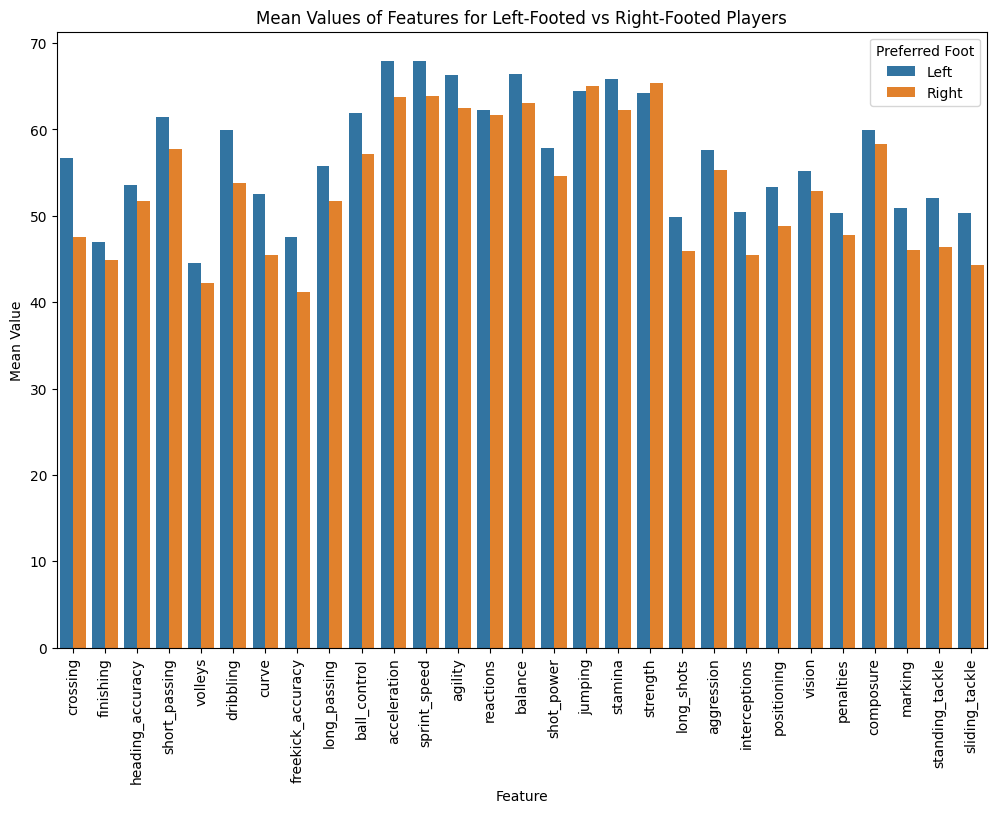

In [68]:
# Calculate the mean for each feature for left-footed and right-footed players
relevant_features = ['crossing',
       'finishing', 'heading_accuracy', 'short_passing', 'volleys',
       'dribbling', 'curve', 'freekick_accuracy', 'long_passing',
       'ball_control', 'acceleration', 'sprint_speed', 'agility', 'reactions',
       'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots',
       'aggression', 'interceptions', 'positioning', 'vision', 'penalties',
       'composure', 'marking', 'standing_tackle', 'sliding_tackle' ,'preferred_foot']
mean_df = df[relevant_features].groupby('preferred_foot').mean().reset_index()

# Plotting the means for each feature
plt.figure(figsize=(12, 8))
mean_df_melted = mean_df.melt(id_vars='preferred_foot', var_name='Feature', value_name='Mean')

sns.barplot(x='Feature', y='Mean', hue='preferred_foot', data=mean_df_melted)
plt.title('Mean Values of Features for Left-Footed vs Right-Footed Players')
plt.xlabel('Feature')
plt.ylabel('Mean Value')
plt.xticks(rotation=90)
plt.legend(title='Preferred Foot')
plt.show()

Almost in every feature, we have an advantage for the left-footed players.

We will generate the distributions of the features we are intrested in (right vs. left) for a better understanding:

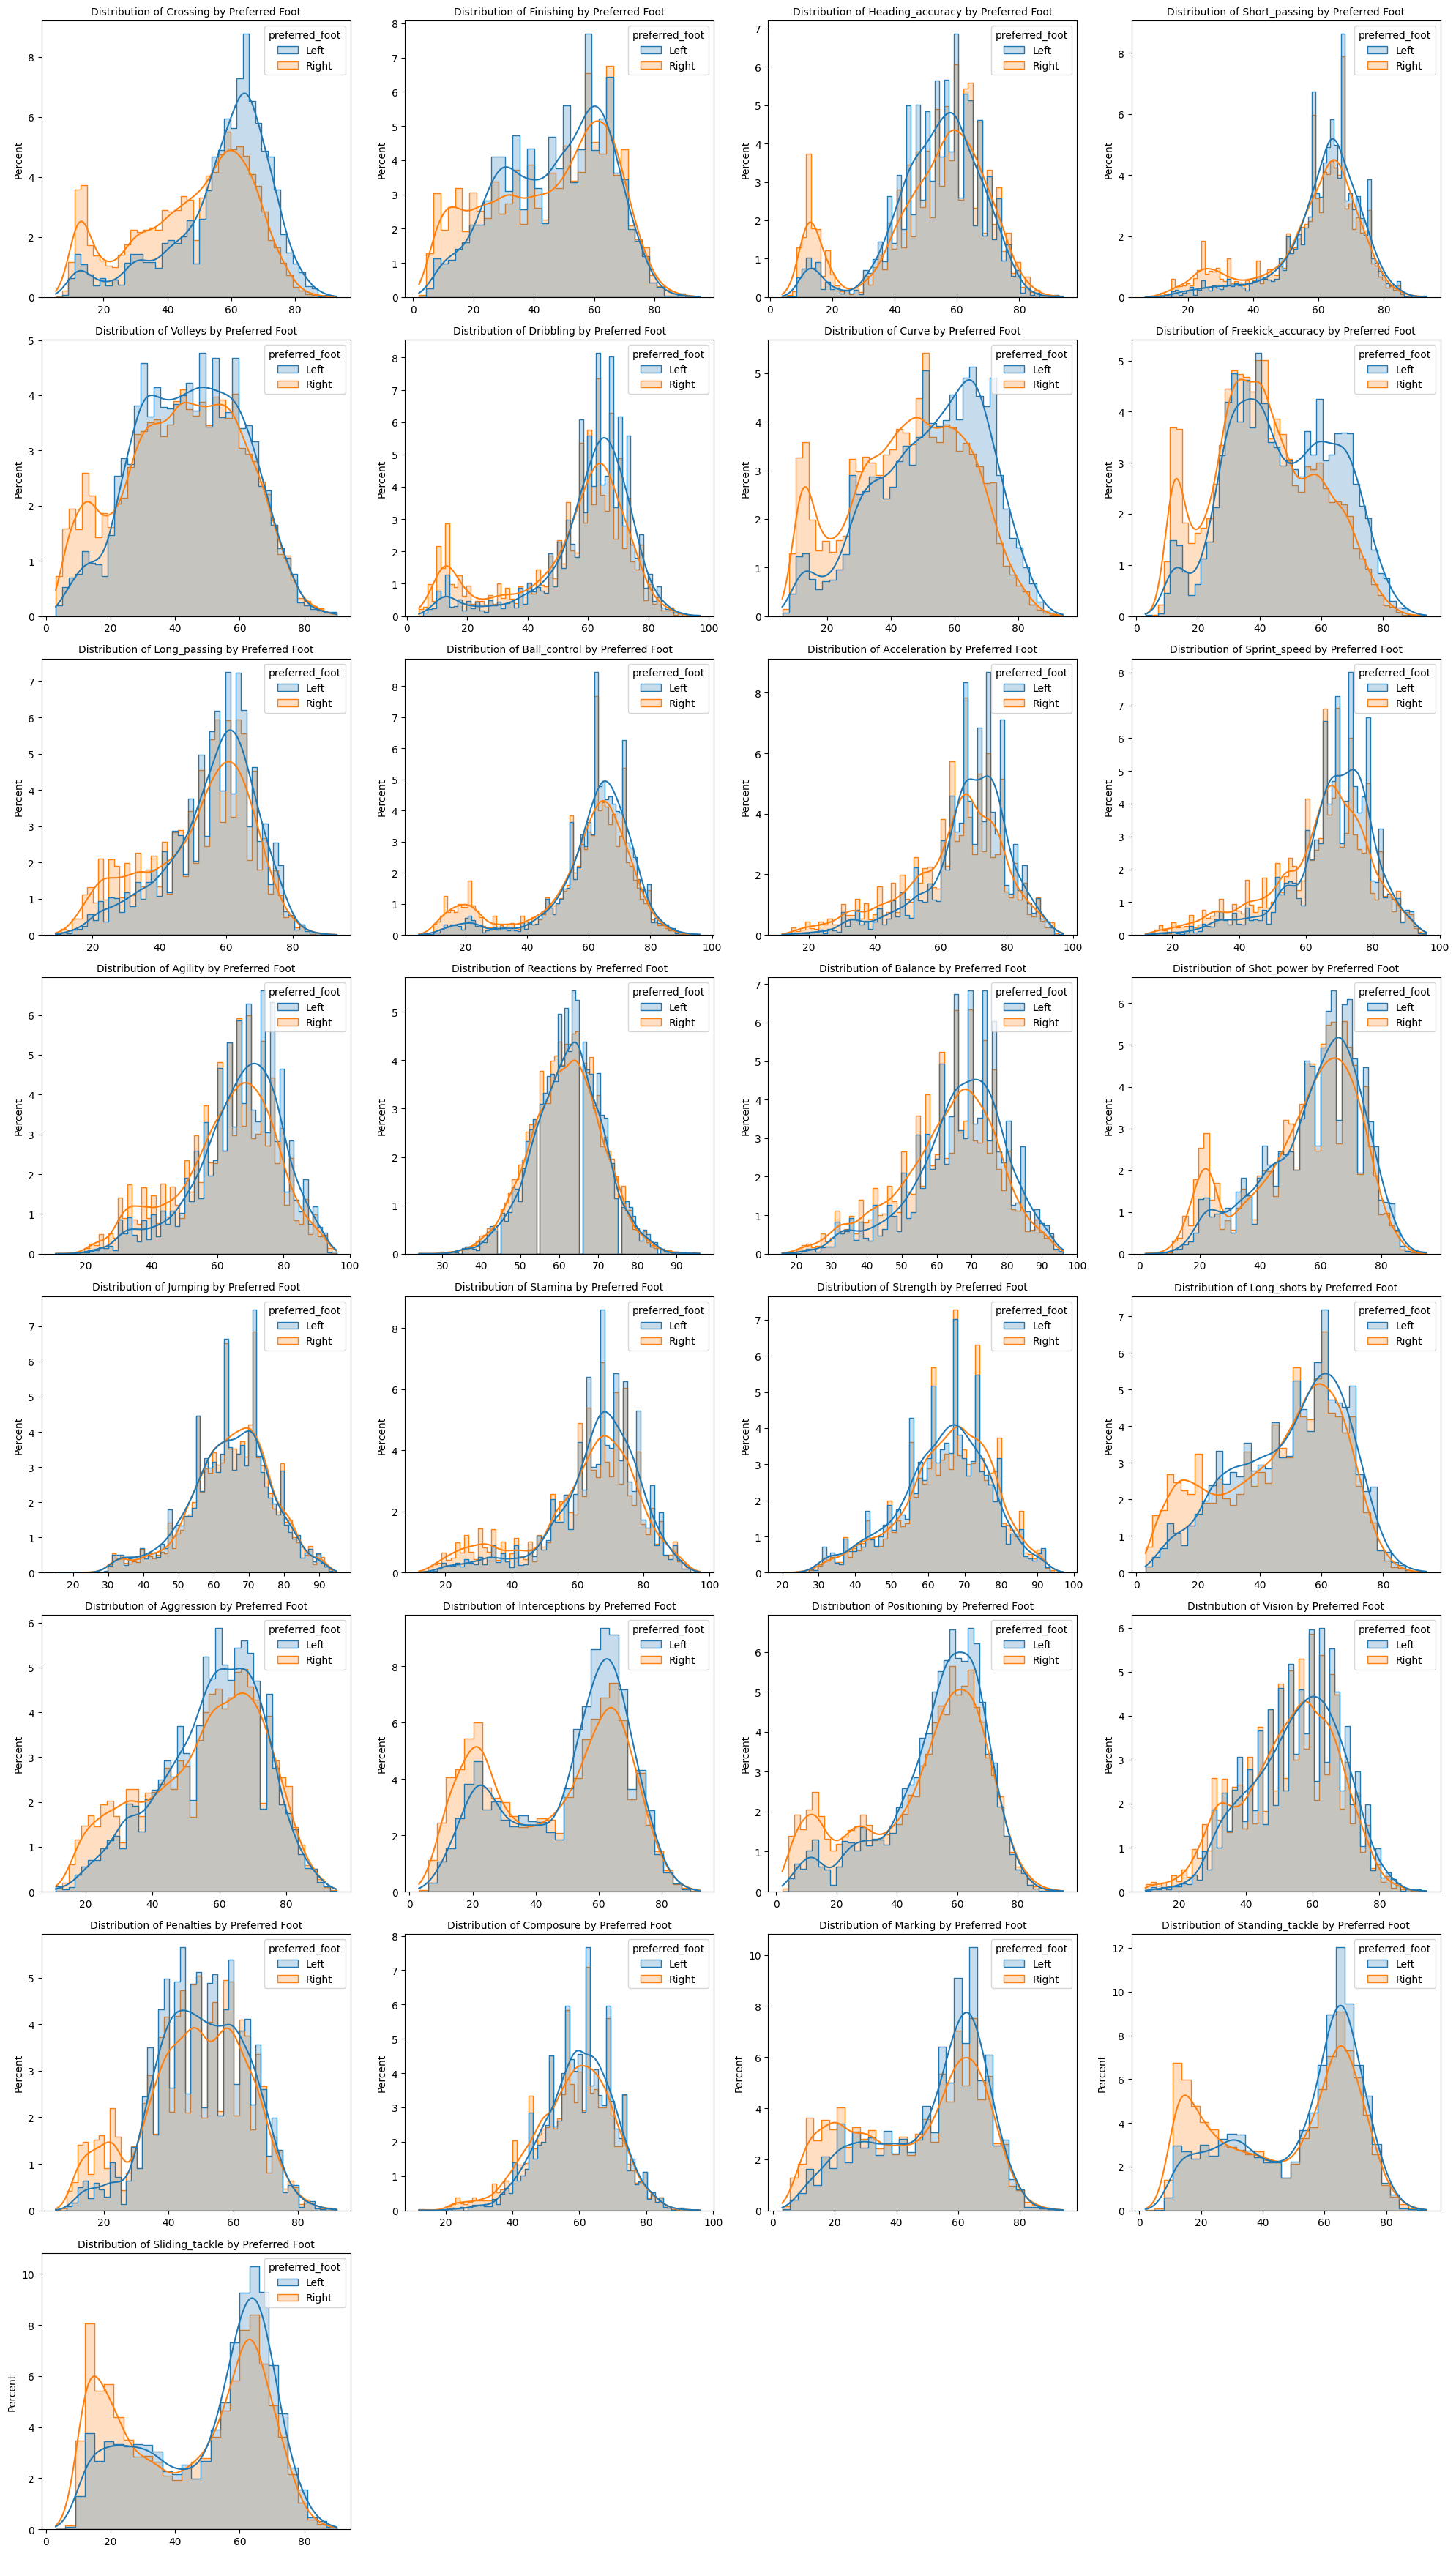

In [69]:
features = ['crossing',
       'finishing', 'heading_accuracy', 'short_passing', 'volleys',
       'dribbling', 'curve', 'freekick_accuracy', 'long_passing',
       'ball_control', 'acceleration', 'sprint_speed', 'agility', 'reactions',
       'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots',
       'aggression', 'interceptions', 'positioning', 'vision', 'penalties',
       'composure', 'marking', 'standing_tackle', 'sliding_tackle']

# Creating a figure with the distributions of all features by preferred foot (percentages)
fig, axes = plt.subplots(nrows=8, ncols=4, figsize=(20, 35))

axes = axes.flatten()

for i, feature in enumerate(features):
    sns.histplot(data=df, x=feature, hue='preferred_foot', stat='percent', element='step', kde=True, common_norm=False, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature.capitalize()} by Preferred Foot', fontsize=10)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Percent')

for j in range(len(features), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

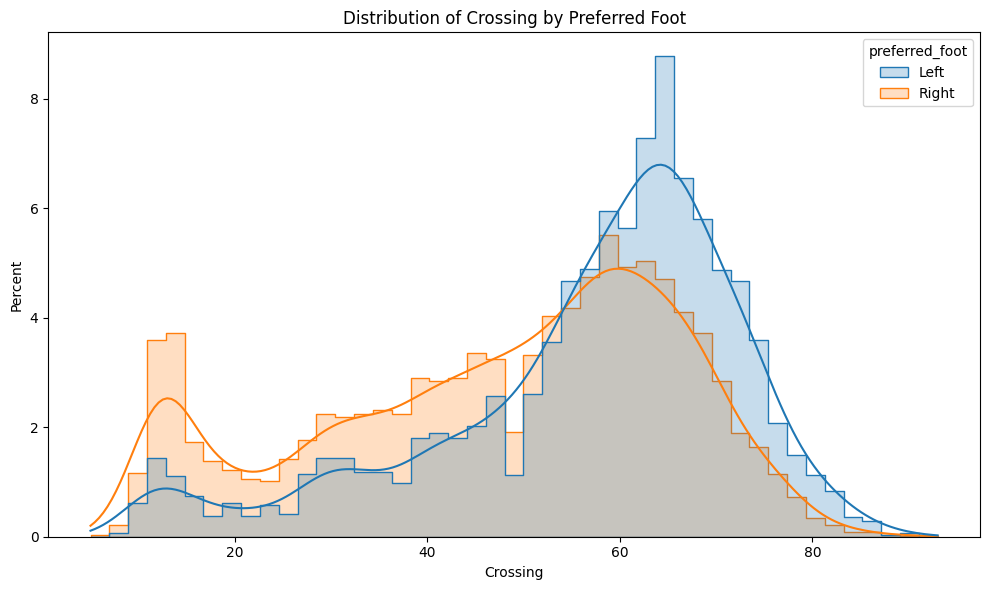

In [70]:
# Creating a figure with the distribution of the 'crossing' feature by preferred foot (percentages)
fig, ax = plt.subplots(figsize=(10, 6))

sns.histplot(data=df, x='crossing', hue='preferred_foot', stat='percent', element='step', kde=True, common_norm=False, ax=ax)
ax.set_title('Distribution of Crossing by Preferred Foot', fontsize=12)
ax.set_xlabel('Crossing')
ax.set_ylabel('Percent')

plt.tight_layout()
plt.show()

-----------

### **Radar Plots**

For the average right and left footed player.

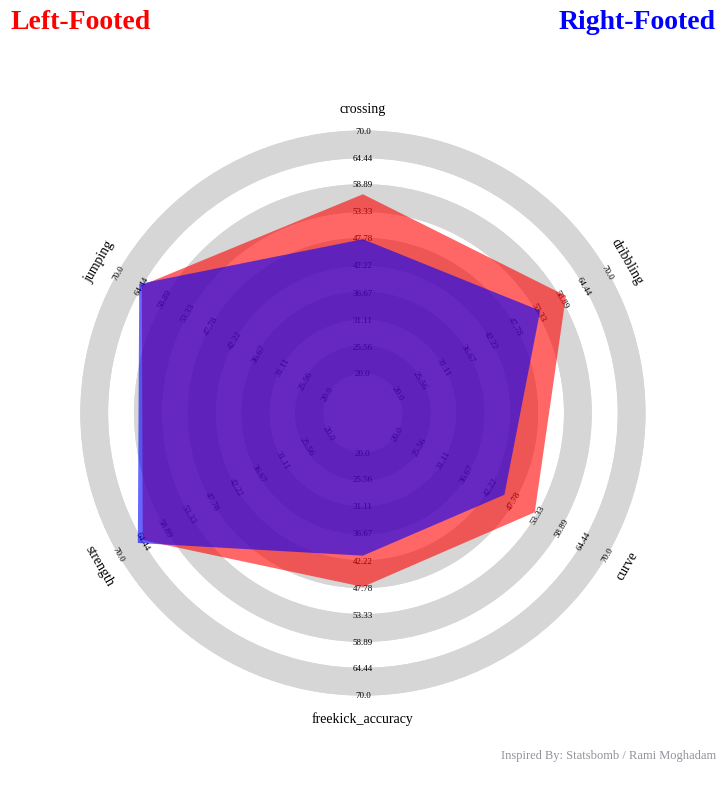

In [71]:
# Calculate the mean values for the specified attributes for both left-footed and right-footed players
attributes = ['crossing', 'dribbling', 'curve', 'freekick_accuracy', 'strength', 'jumping']
left_footed_avg = df[df['preferred_foot'] == 'Left'][attributes].mean()
right_footed_avg = df[df['preferred_foot'] == 'Right'][attributes].mean()

params = attributes
values = [
    left_footed_avg.values.tolist(),
    right_footed_avg.values.tolist()
]
radar_color = ['red', 'blue']

# Define the ranges for each attribute (min and max values)
ranges = [(20, 70) for _ in attributes]  # Assuming the attributes are rated from 0 to 100

radar = Radar()
fig, ax = radar.plot_radar(params=params, values=values, radar_color=radar_color,
                           title={'title_name': 'Left-Footed',
                                  'title_color': 'red',
                                  'subtitle_name': '',
                                  'subtitle_color': 'gray', 'title_name_2': 'Right-Footed',
                                  'title_color_2': 'blue',
                                  'subtitle_name_2': '',
                                  'subtitle_color_2': 'gray'},
                           compare=True,
                           figsize=(10, 10),
                           ranges=ranges)

plt.show()

We can notice a significant advantage for the average left-footed over the avg right-footed in: crossing, dribbling, curve and freekick accuracy. On the other hand, we can see a slight advantage for the average right-footed in: strength and jumping.

-----------

## **Statistical Analysis and Test**

In [72]:
# p-value for age feature (sanity check)
left_footed = df[df['preferred_foot'] == 'Left']['age']
right_footed = df[df['preferred_foot'] == 'Right']['age']

u_stat, p_value = stats.mannwhitneyu(left_footed, right_footed, alternative='greater')

print(f'U-statistic: {u_stat}')
print(f'P-value: {p_value}')

if p_value < 0.05:
    print("There is a statistically significant difference in dribbling scores, with left-footed players likely having better dribbling skills.")
else:
    print("There is no statistically significant difference in dribbling scores between left-footed and right-footed players.")

U-statistic: 28805060.0
P-value: 0.4308499622148099
There is no statistically significant difference in dribbling scores between left-footed and right-footed players.


In [73]:
import numpy as np
import scipy.stats as stats
import pandas as pd

# Define the list of features and relevant columns
features = ['crossing', 'finishing', 'heading_accuracy', 'short_passing', 'volleys',
            'dribbling', 'curve', 'freekick_accuracy', 'long_passing', 'ball_control',
            'acceleration', 'sprint_speed', 'agility', 'reactions', 'balance', 'shot_power',
            'jumping', 'stamina', 'strength', 'long_shots', 'aggression', 'interceptions',
            'positioning', 'vision', 'penalties', 'composure', 'marking', 'standing_tackle',
            'sliding_tackle']

columns_of_interest = features + ['preferred_foot']
df_relevant = df[columns_of_interest]

lefties = df_relevant[df_relevant['preferred_foot'] == 'Left']
righties = df_relevant[df_relevant['preferred_foot'] == 'Right']

# Function to calculate the 95% confidence interval
def confidence_interval(data):
    mean = np.mean(data)
    ci = stats.t.interval(0.95, len(data) - 1, loc=mean, scale=stats.sem(data))
    return mean, ci

def welch_ttest(x, y):
    return stats.ttest_ind(x, y, equal_var=False)

def mann_whitney_u(x, y):
    return stats.mannwhitneyu(x, y, alternative='two-sided')

def kolmogorov_smirnov(x, y):
    return stats.ks_2samp(x, y)

results = {'Welch T-Test': {}, 'Mann-Whitney U Test': {}, 'Kolmogorov-Smirnov Test': {},
           'Left-footed Mean and CI': {}, 'Right-footed Mean and CI': {}}

for feature in features:
    t_stat, p_value = welch_ttest(lefties[feature], righties[feature])
    results['Welch T-Test'][feature] = {'t_statistic': t_stat, 'p_value': p_value}

    u_stat, p_value = mann_whitney_u(lefties[feature], righties[feature])
    results['Mann-Whitney U Test'][feature] = {'U_statistic': u_stat, 'p_value': p_value}

    ks_stat, p_value = kolmogorov_smirnov(lefties[feature], righties[feature])
    results['Kolmogorov-Smirnov Test'][feature] = {'KS_statistic': ks_stat, 'p_value': p_value}

    left_mean, left_ci = confidence_interval(lefties[feature])
    results['Left-footed Mean and CI'][feature] = {'mean': left_mean, '95% CI': left_ci}

    right_mean, right_ci = confidence_interval(righties[feature])
    results['Right-footed Mean and CI'][feature] = {'mean': right_mean, '95% CI': right_ci}

results_df = pd.concat({k: pd.DataFrame(v).transpose() for k, v in results.items()}, axis=1)

print("Statistical tests between left-footed and right-footed players in all features:")
results_df


Statistical tests between left-footed and right-footed players in all features:


Welch T-Test                Mann-Whitney U Test  \
                   t_statistic        p_value         U_statistic   
crossing             30.910551  4.989215e-198          37385070.5   
finishing             6.549575   6.134674e-11          30094602.0   
heading_accuracy      6.855290   7.602900e-12          28975495.5   
short_passing        16.173823   5.569978e-58          32168069.5   
volleys               7.933706   2.430920e-15          30626234.5   
dribbling            20.853473   2.806665e-94          33642770.0   
curve                22.781925  5.140852e-111          35060258.5   
freekick_accuracy    20.726281   1.286299e-92          34452639.5   
long_passing         16.126922   1.350015e-57          32686446.0   
ball_control         18.753084   5.421699e-77          32739413.0   
acceleration         17.572103   7.419004e-68          33471727.5   
sprint_speed         17.282810   9.546127e-66          33369484.5   
agility              15.778464   3.219663e-55          32948043.0   
reactions             3.928511   8.627823e-05          29846783.0   
balance              13.608167   1.142177e-41          32582457.5   
shot_power           11.255376   3.710648e-29          31536406.5   
jumping              -2.877018   4.026927e-03          27929716.0   
stamina              14.202892   2.933990e-45          31875792.0   
strength             -5.276975   1.353299e-07          27089360.0   
long_shots           11.947801   1.312155e-32          31729091.0   
aggression            8.241596   1.972968e-16          30421242.5   
interceptions        14.417775   1.634211e-46          32426386.5   
positioning          14.894839   1.515017e-49          31778595.0   
vision                9.373891   9.150314e-21          31180087.5   
penalties             9.833049   1.094178e-22          30814673.5   
composure             8.700433   3.997028e-18          30779845.5   
marking              15.113047   6.991453e-51          32550036.0   
standing_tackle      15.938628   2.699260e-56          32829868.0   
sliding_tackle       17.161838   8.672619e-65          33456463.5   

                                 Kolmogorov-Smirnov Test                 \
                         p_value            KS_statistic        p_value   
crossing           2.346511e-190                0.229814  3.424720e-149   
finishing           4.864218e-06                0.090060   4.682628e-23   
heading_accuracy    4.502043e-01                0.081346   6.952602e-19   
short_passing       2.477691e-31                0.097755   4.285837e-27   
volleys             1.734357e-10                0.082165   2.936763e-19   
dribbling           2.137863e-62                0.127641   5.955698e-46   
curve              1.525332e-102                0.159622   9.280509e-72   
freekick_accuracy   4.324557e-84                0.141578   1.767916e-56   
long_passing        5.353197e-41                0.105992   8.686794e-32   
ball_control        4.487519e-42                0.106241   6.180690e-32   
acceleration        3.103672e-58                0.138651   3.553178e-54   
sprint_speed        8.111812e-56                0.126315   5.233100e-45   
agility             2.153025e-46                0.104146   1.056955e-30   
reactions           1.935364e-04                0.038676   1.340038e-04   
balance             5.970370e-39                0.101768   2.473924e-29   
shot_power          2.375413e-21                0.068458   1.699143e-13   
jumping             4.934367e-03                0.024792   3.834373e-02   
stamina             1.833084e-26                0.095613   6.164960e-26   
strength            1.371757e-08                0.048481   5.558974e-07   
long_shots          3.543892e-24                0.096160   3.137956e-26   
aggression          1.312299e-08                0.077975   2.193749e-17   
interceptions       5.728763e-36                0.120435   6.092352e-41   
positioning         6.172396e-25                0.113282   2.924027e-36   
vis

In [74]:
few_features = ['crossing', 'dribbling', 'curve', 'freekick_accuracy']

columns_of_interest_few = few_features + ['preferred_foot']
df_relevant_few = df[columns_of_interest_few]

lefties_few = df_relevant_few[df_relevant_few['preferred_foot'] == 'Left']
righties_few = df_relevant_few[df_relevant_few['preferred_foot'] == 'Right']

def confidence_interval(data):
    mean = np.mean(data)
    ci = stats.t.interval(0.95, len(data) - 1, loc=mean, scale=stats.sem(data))
    return mean, ci

def welch_ttest(x, y):
    return stats.ttest_ind(x, y, equal_var=False)

def mann_whitney_u(x, y):
    return stats.mannwhitneyu(x, y, alternative='two-sided')

def kolmogorov_smirnov(x, y):
    return stats.ks_2samp(x, y)

results_few = {
    'Welch T-Test': {},
    'Mann-Whitney U Test': {},
    'Kolmogorov-Smirnov Test': {},
    'Left-footed Mean and CI': {},
    'Right-footed Mean and CI': {}
}

for feature in few_features:
    t_stat, p_value = welch_ttest(lefties_few[feature], righties_few[feature])
    results_few['Welch T-Test'][feature] = {'t_statistic': t_stat, 'p_value': p_value}

    u_stat, p_value = mann_whitney_u(lefties_few[feature], righties_few[feature])
    results_few['Mann-Whitney U Test'][feature] = {'U_statistic': u_stat, 'p_value': p_value}

    ks_stat, p_value = kolmogorov_smirnov(lefties_few[feature], righties_few[feature])
    results_few['Kolmogorov-Smirnov Test'][feature] = {'KS_statistic': ks_stat, 'p_value': p_value}

    left_mean, left_ci = confidence_interval(lefties_few[feature])
    results_few['Left-footed Mean and CI'][feature] = {'mean': left_mean, '95% CI': left_ci}

    right_mean, right_ci = confidence_interval(righties_few[feature])
    results_few['Right-footed Mean and CI'][feature] = {'mean': right_mean, '95% CI': right_ci}

results_df_few = pd.concat({k: pd.DataFrame(v).transpose() for k, v in results_few.items()}, axis=1)

print("Statistical tests between left-footed and right-footed players in chosen features:")
results_df_few


Statistical tests between left-footed and right-footed players in chosen features:


Welch T-Test                Mann-Whitney U Test  \
                   t_statistic        p_value         U_statistic   
crossing             30.910551  4.989215e-198          37385070.5   
dribbling            20.853473   2.806665e-94          33642770.0   
curve                22.781925  5.140852e-111          35060258.5   
freekick_accuracy    20.726281   1.286299e-92          34452639.5   

                                 Kolmogorov-Smirnov Test                 \
                         p_value            KS_statistic        p_value   
crossing           2.346511e-190                0.229814  3.424720e-149   
dribbling           2.137863e-62                0.127641   5.955698e-46   
curve              1.525332e-102                0.159622   9.280509e-72   
freekick_accuracy   4.324557e-84                0.141578   1.767916e-56   

                  Left-footed Mean and CI  \
                                     mean   
crossing                        56.726336   
dribbling                       59.975318   
curve                           52.578241   
freekick_accuracy               47.569135   

                                                            \
                                                    95% CI   
crossing           (56.235744951748615, 57.21692698690464)   
dribbling            (59.5050749019306, 60.44556013281658)   
curve               (52.04785587020128, 53.10862627693508)   
freekick_accuracy  (47.04207908116473, 48.096190748693886)   

                  Right-footed Mean and CI  \
                                      mean   
crossing                         47.569335   
dribbling                        53.856904   
curve                            45.442638   
freekick_accuracy                41.210072   

                                                             
                                                     95% CI  
crossing           (47.258528035900746, 47.880141146306634)  
dribbling           (53.525684984410184, 54.18812388287086)  
curve                (45.13323801924926, 45.75203881116943)  
freekick_accuracy   (40.920248713311835, 41.49989496276392)

The results concluded from the statistical tests also indicate an advantage (in avarage) for the left-footed players, in the features that are shown above.

### <u>Statistical Tests by Categories:</u>

Next, we want to divide the players into different subgroups:
1. **Position:** 'Forward'/'Midfielder'/'Defender'/'Goalkeeper'.
2. **Height:** '160-170'/'170-180'/'180-190'.

We will perform the Mann-Whitney U test again for each of the features, for each of the subgroups:

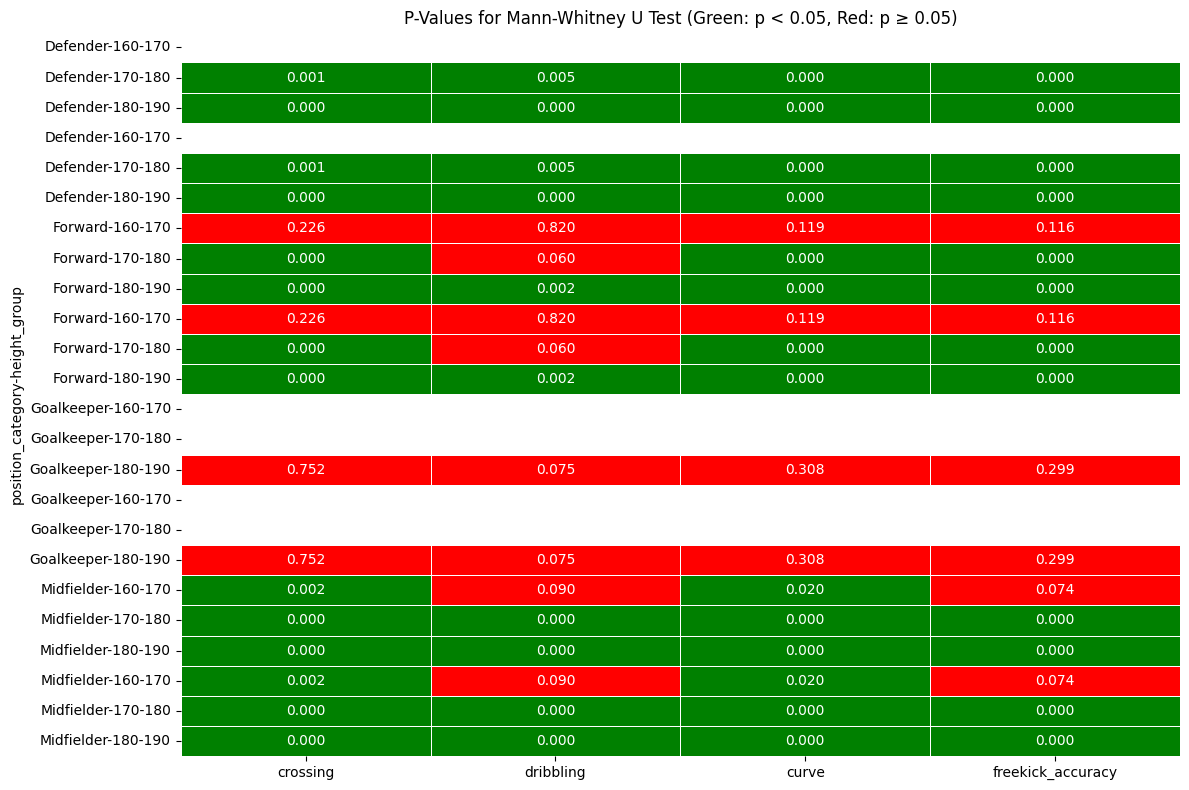

In [78]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

features = ['crossing',
       'finishing', 'heading_accuracy', 'short_passing', 'volleys',
       'dribbling', 'curve', 'freekick_accuracy', 'long_passing',
       'ball_control', 'acceleration', 'sprint_speed', 'agility', 'reactions',
       'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots',
       'aggression', 'interceptions', 'positioning', 'vision', 'penalties',
       'composure', 'marking', 'standing_tackle', 'sliding_tackle']

df_filtered = df.dropna(subset=['preferred_foot', 'age', 'height_cm', 'weight_kgs', 'positions'])

# Defining a function to categorize positions into broader groups
def categorize_position(position_str):
    if 'ST' in position_str or 'CF' in position_str or 'LW' in position_str or 'RW' in position_str:
        return 'Forward'
    elif 'CM' in position_str or 'CAM' in position_str or 'CDM' in position_str or 'RM' in position_str or 'LM' in position_str:
        return 'Midfielder'
    elif 'CB' in position_str or 'RB' in position_str or 'LB' in position_str:
        return 'Defender'
    elif 'GK' in position_str:
        return 'Goalkeeper'
    else:
        return 'Other'

df_filtered['position_category'] = df_filtered['positions'].apply(categorize_position)

# Binning players by height (in 10 cm intervals)
df_filtered['height_group'] = pd.cut(df_filtered['height_cm'], bins=range(160, 200, 10), right=False, labels=['160-170', '170-180', '180-190'])

df_filtered = df_filtered[features + ['position_category', 'preferred_foot', 'height_group']]

grouped_df = df_filtered.groupby(['position_category', 'preferred_foot', 'height_group']).mean()
group_counts = df_filtered.groupby(['position_category', 'preferred_foot', 'height_group']).size().unstack('preferred_foot')
metrics_for_heatmap = ['crossing', 'dribbling', 'curve', 'freekick_accuracy']
p_values = pd.DataFrame(index=grouped_df.index.droplevel('preferred_foot'), columns=metrics_for_heatmap)

# Perform Mann-Whitney U Test and store p-values
for index in grouped_df.index.droplevel('preferred_foot'):
    position, height_group = index

    left_group = df_filtered[(df_filtered['preferred_foot'] == 'Left') &
                             (df_filtered['position_category'] == position) &
                             (df_filtered['height_group'] == height_group)]

    right_group = df_filtered[(df_filtered['preferred_foot'] == 'Right') &
                              (df_filtered['position_category'] == position) &
                              (df_filtered['height_group'] == height_group)]

    if len(left_group) > 0 and len(right_group) > 0:
        for metric in metrics_for_heatmap:
            if len(left_group[metric]) >= 30 and len(right_group[metric]) >= 30:
                _, p_val = stats.mannwhitneyu(left_group[metric], right_group[metric], alternative='two-sided')
                p_values.loc[(position, height_group), metric] = p_val
            else:
                p_values.loc[(position, height_group), metric] = np.nan

binary_p_values = p_values.applymap(lambda x: 1 if x < 0.05 else 0)

cmap = ListedColormap(['red', 'green'])

plt.figure(figsize=(12, 8))
sns.heatmap(binary_p_values, annot=p_values, fmt=".3f", cmap=cmap, cbar=False, linewidths=0.5, mask=p_values.isnull())

plt.title('P-Values for Mann-Whitney U Test (Green: p < 0.05, Red: p ≥ 0.05)')
plt.tight_layout()
plt.show()

And the P-values are:

In [79]:
p_values

crossing dribbling     curve freekick_accuracy
position_category height_group                                                
Defender          160-170            NaN       NaN       NaN               NaN
                  170-180       0.001301  0.004788  0.000018          0.000001
                  180-190            0.0       0.0       0.0               0.0
                  160-170            NaN       NaN       NaN               NaN
                  170-180       0.001301  0.004788  0.000018          0.000001
                  180-190            0.0       0.0       0.0               0.0
Forward           160-170       0.225825  0.820012  0.119213          0.116122
                  170-180            0.0  0.060264  0.000008               0.0
                  180-190            0.0  0.002219       0.0          0.000012
                  160-170       0.225825  0.820012  0.119213          0.116122
                  170-180            0.0  0.060264  0.000008               0.0
                  180-190            0.0  0.002219       0.0          0.000012
Goalkeeper        160-170            NaN       NaN       NaN               NaN
                  170-180            NaN       NaN       NaN               NaN
                  180-190       0.752334  0.074725  0.308478          0.299012
                  160-170            NaN       NaN       NaN               NaN
                  170-180            NaN       NaN       NaN               NaN
                  180-190       0.752334  0.074725  0.308478          0.299012
Midfielder        160-170       0.001944  0.089506  0.020019          0.073717
                  170-180            0.0  0.000017       0.0          0.000006
                  180-190            0.0       0.0       0.0               0.0
                  160-170       0.001944  0.089506  0.020019          0.073717
                  170-180            0.0  0.000017       0.0          0.000006
                  180-190            0.0       0.0       0.0               0.0

### <u>Feature Importance and SHAP Values:</u>

We will now look at the feature importance and SHAP values of our features.

Feature importance for crossing
              Feature  Importance
27          dribbling    0.554486
5               curve    0.104347
19        positioning    0.101906
2    heading_accuracy    0.044670
25     sliding_tackle    0.029452
6        long_passing    0.022207
24    standing_tackle    0.021557
26       ball_control    0.011467
9        sprint_speed    0.010886
3       short_passing    0.010450
0      preferred_foot    0.007202
8        acceleration    0.006891
7   freekick_accuracy    0.006882
20             vision    0.006605
15           strength    0.005952
23            marking    0.005829
18      interceptions    0.005590
16         long_shots    0.005180
10            agility    0.005001
13            jumping    0.004556
14            stamina    0.004503
12         shot_power    0.004029
21          penalties    0.004025
11            balance    0.003955
17         aggression    0.003606
4             volleys    0.003064
22          composure    0.003042
1           fini

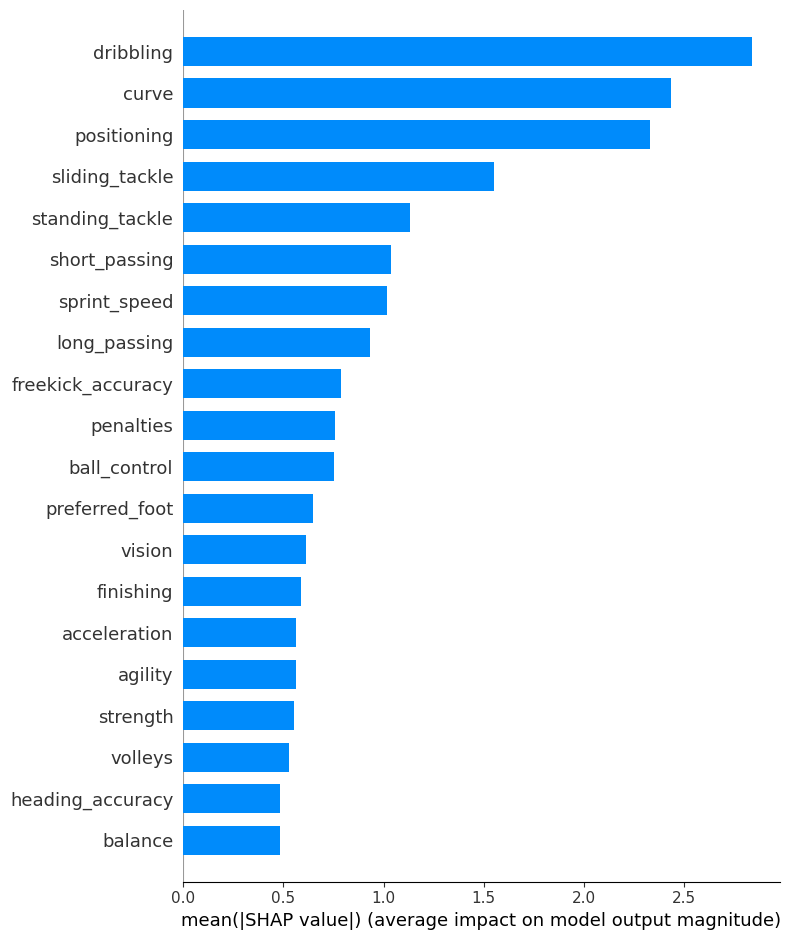

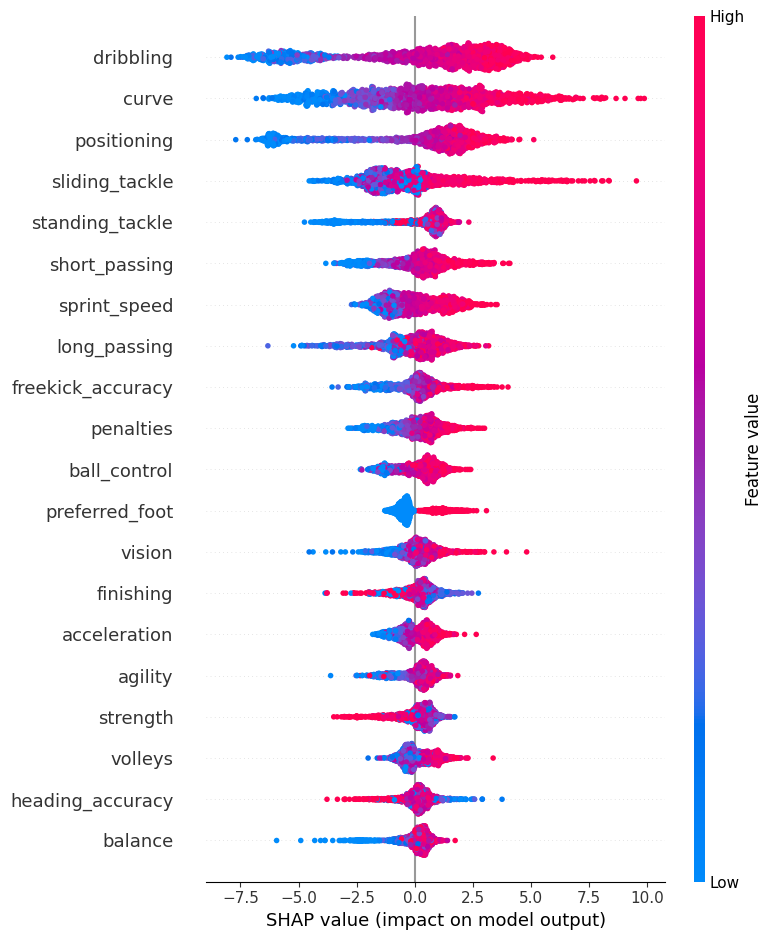

Feature importance for dribbling
              Feature  Importance
27       ball_control    0.694596
20        positioning    0.146424
3    heading_accuracy    0.038828
25    standing_tackle    0.023031
2           finishing    0.019167
9        acceleration    0.012998
6               curve    0.010992
11            agility    0.005524
26     sliding_tackle    0.004901
1            crossing    0.004795
21             vision    0.004381
17         long_shots    0.003922
16           strength    0.003908
10       sprint_speed    0.003895
13         shot_power    0.002220
7        long_passing    0.002187
19      interceptions    0.002099
24            marking    0.001934
22          penalties    0.001771
5             volleys    0.001730
12            balance    0.001618
8   freekick_accuracy    0.001601
18         aggression    0.001505
14            jumping    0.001457
4       short_passing    0.001438
15            stamina    0.001301
23          composure    0.001282
0      preferre

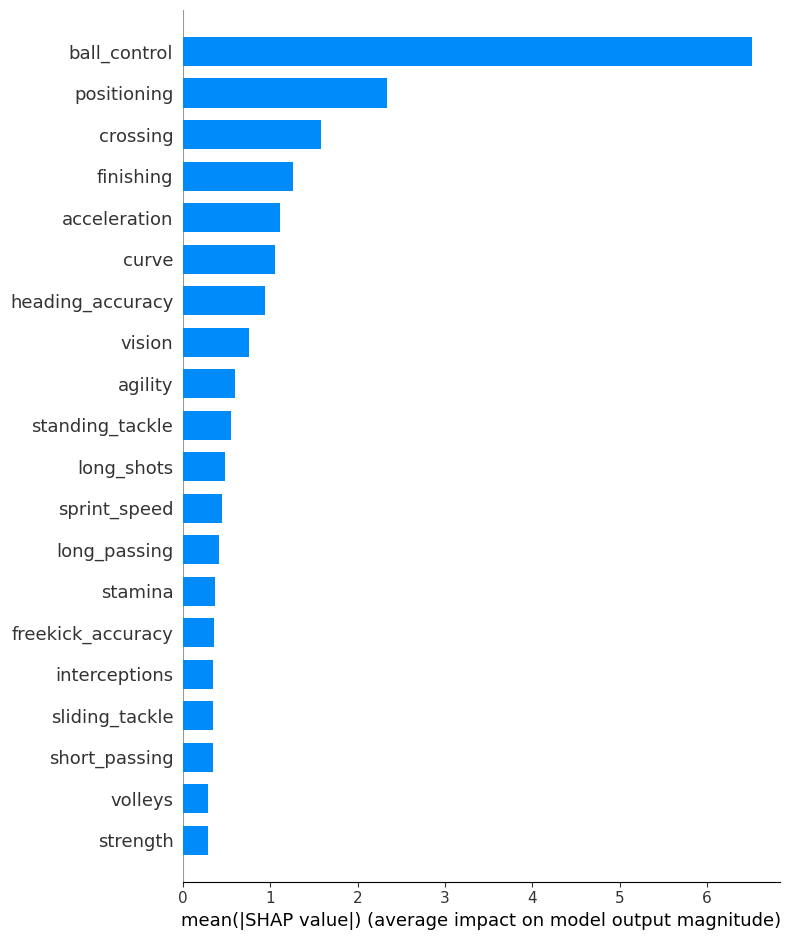

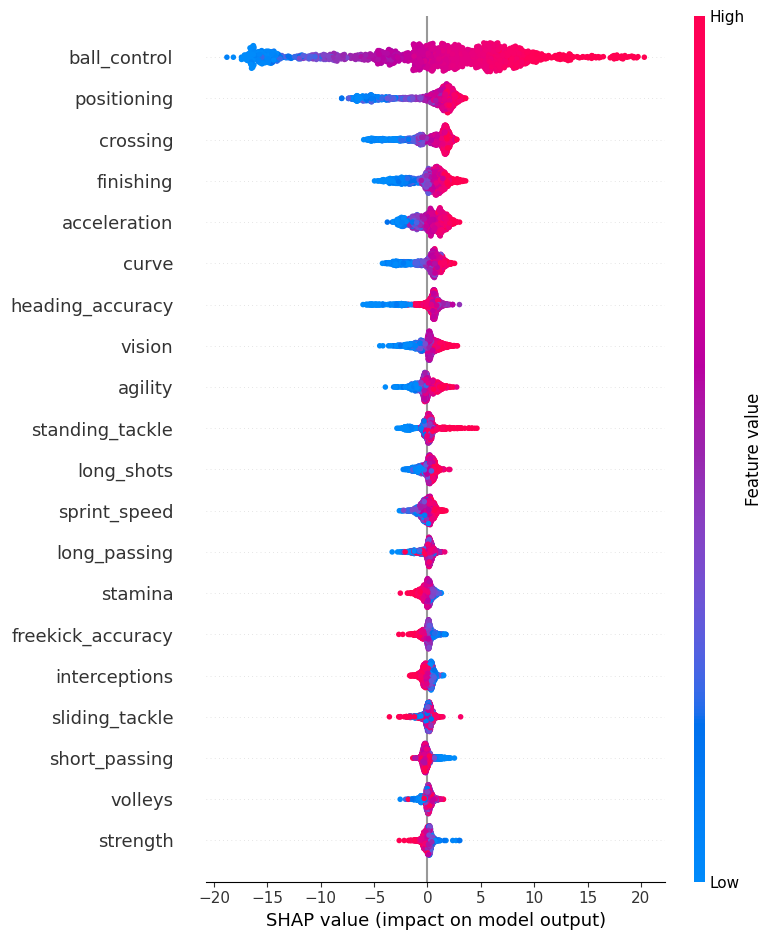

Feature importance for curve
              Feature  Importance
27          dribbling    0.454966
16         long_shots    0.150800
7   freekick_accuracy    0.135319
5             volleys    0.051959
3    heading_accuracy    0.034612
24    standing_tackle    0.031044
1            crossing    0.027516
19        positioning    0.026369
26       ball_control    0.014675
10            agility    0.006165
20             vision    0.006105
12         shot_power    0.006049
22          composure    0.005193
21          penalties    0.005164
15           strength    0.003674
18      interceptions    0.003639
23            marking    0.003637
25     sliding_tackle    0.003502
6        long_passing    0.003435
17         aggression    0.003422
2           finishing    0.003418
14            stamina    0.003317
11            balance    0.003206
8        acceleration    0.003050
9        sprint_speed    0.002945
13            jumping    0.002858
0      preferred_foot    0.002003
4       short_passi

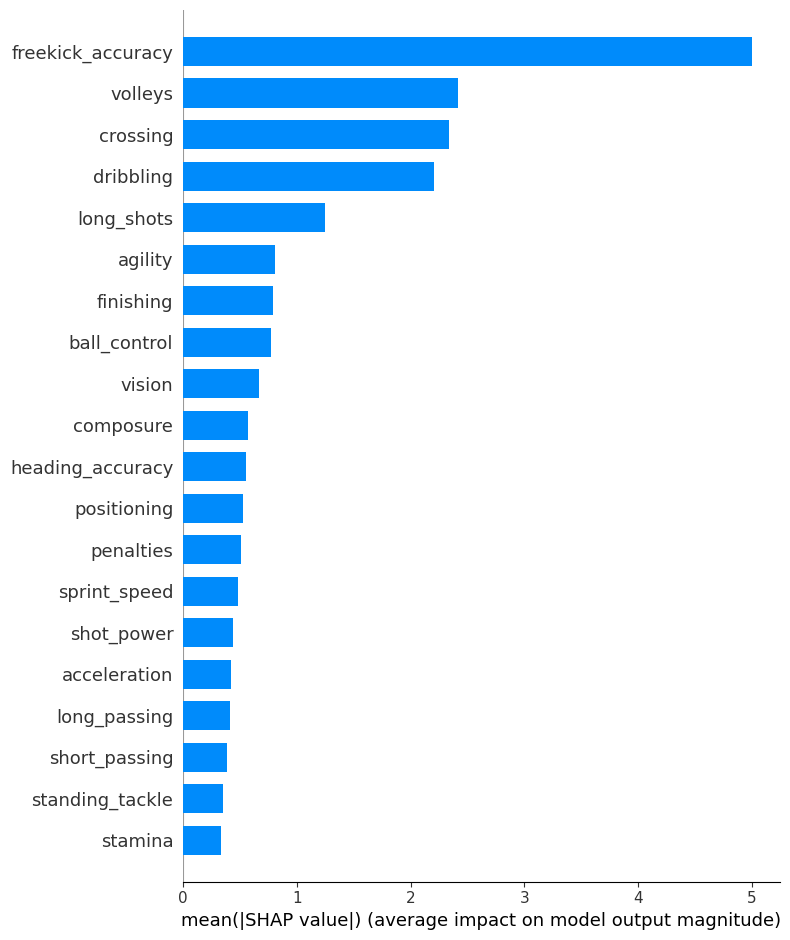

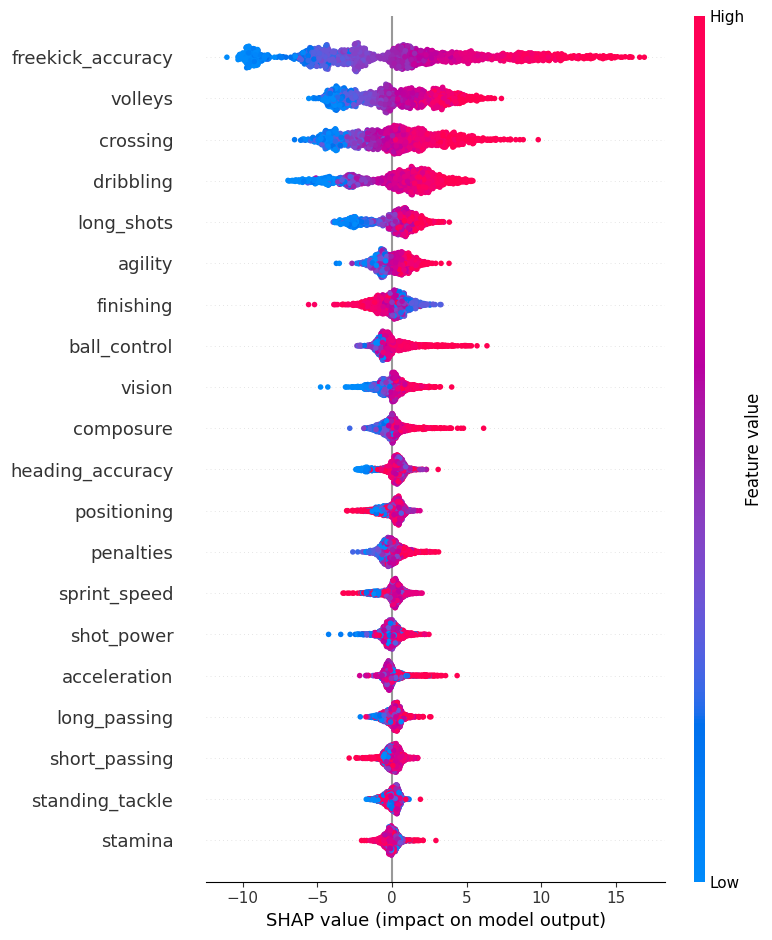

Feature importance for freekick_accuracy
             Feature  Importance
6              curve    0.575344
16        long_shots    0.136284
19       positioning    0.053070
21         penalties    0.025126
24   standing_tackle    0.019936
7       long_passing    0.019350
20            vision    0.017959
1           crossing    0.014453
25    sliding_tackle    0.012350
18     interceptions    0.010560
9       sprint_speed    0.009614
27         dribbling    0.009111
12        shot_power    0.009098
26      ball_control    0.007901
5            volleys    0.007521
3   heading_accuracy    0.006804
23           marking    0.006094
8       acceleration    0.006026
22         composure    0.005932
15          strength    0.005823
11           balance    0.005794
2          finishing    0.005763
13           jumping    0.005620
17        aggression    0.005589
4      short_passing    0.005173
14           stamina    0.005075
10           agility    0.004765
0     preferred_foot    0.003867
Me

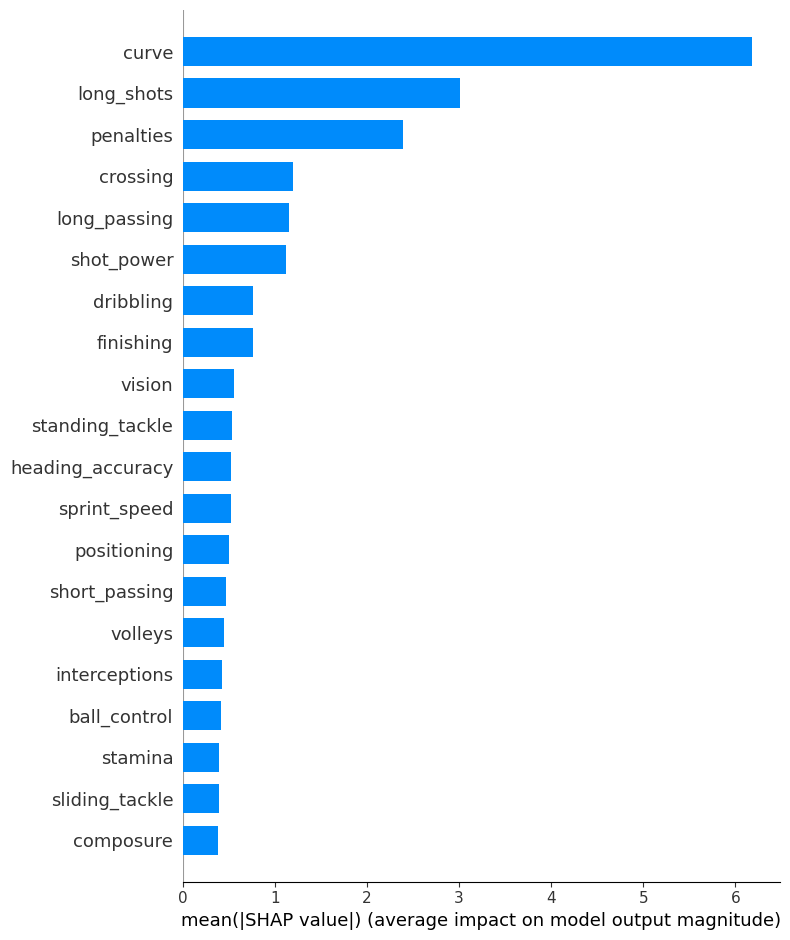

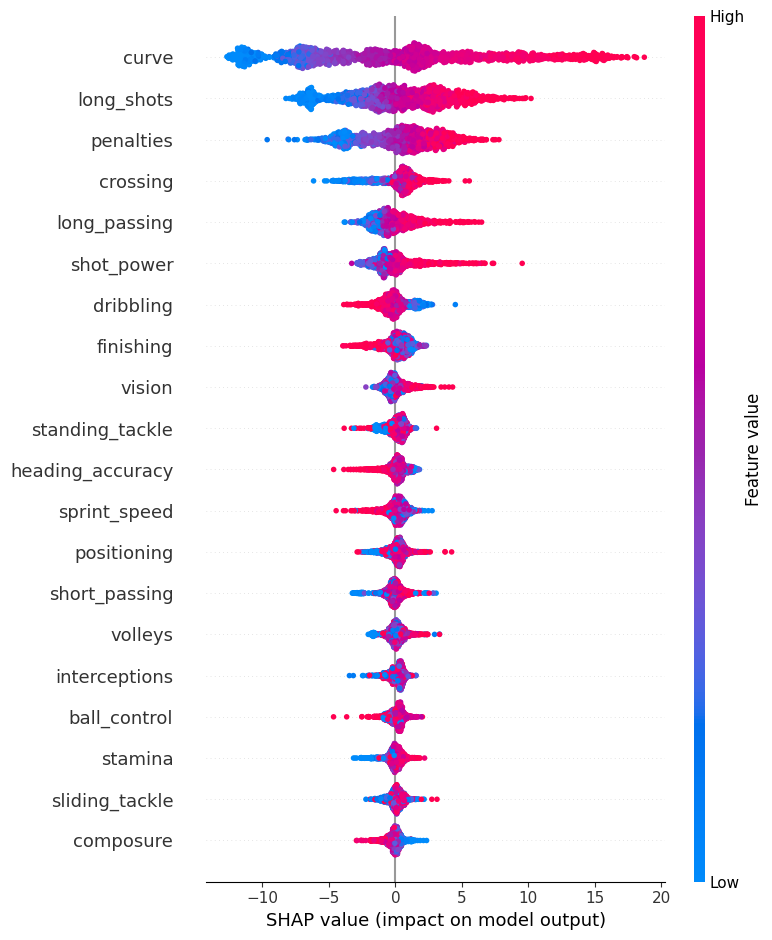

In [90]:
# Select features and target variable
features = ['preferred_foot', 'crossing', 'finishing', 'heading_accuracy', 'short_passing', 'volleys',
       'curve', 'long_passing',
       'freekick_accuracy', 'acceleration', 'sprint_speed', 'agility',
       'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots',
       'aggression', 'interceptions', 'positioning', 'vision', 'penalties',
       'composure', 'marking', 'standing_tackle', 'sliding_tackle', 'ball_control', 'dribbling']

for feature in ['crossing', 'dribbling', 'curve', 'freekick_accuracy']:
  print("Feature importance for %s" % feature)
  X = df[[f for f in features if f != feature]]
  X['preferred_foot'] = X['preferred_foot'].apply(lambda x: 1 if x == 'Left' else 0)
  y = df[feature]

  # Split the data into training and testing sets (90% train, 10% test)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=df['preferred_foot'])

  # Train the XGBoost model
  xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
  xgb_model.fit(X_train, y_train)

  # Feature importance
  importances = xgb_model.feature_importances_
  feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
  print(feature_importance_df.sort_values(by='Importance', ascending=False))

  # Predict on the test set
  y_pred = xgb_model.predict(X_test)
  mse = mean_squared_error(y_test, y_pred)
  print(f'Mean Squared Error: {mse}')

  # SHAP values
  explainer = shap.Explainer(xgb_model, X_train)
  shap_values = explainer(X_test)

  # Plot feature importances
  shap.summary_plot(shap_values, X_test, plot_type="bar")

  # Plot SHAP values for the test set
  shap.summary_plot(shap_values, X_test)



The feature importance and SHAP values indicates an insignificant impact for the 'preferred_foot' feature. Quite an opposite conclusion than the statistical tests' conclusion.